<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook

# Background_subtract() for MIRI LRS SLIT
<span style="color:red"> **Instruments Affected**</span>: MIRI

### Table of Contents
<div style="text-align: left"> 

<br> [Imports](#imports_ID) <br> [Introduction](#intro_ID) <br> [Get Documentaion String for Markdown Blocks](#markdown_from_docs) <br> [Loading Data](#data_ID) <br> [Run JWST Pipeline](#pipeline_ID) <br> [Create Figure or Print Output](#residual_ID) <br> [About This Notebook](#about_ID) <br>

</div>

<a id="imports_ID"></a>
# Imports
List the library imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* jwst.datamodels for building model for JWST Pipeline
* jwst.module.PipelineStep is the pipeline step being tested
* matplotlib.pyplot.plt to generate plot
* shutil, glob for basic OS operations

* pysiaf for retrieving SIAF information
* miricoord for coordinate transformations


[Top of Page](#title_ID)

In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats as stats
import numpy as np
from glob import glob
import shutil
import logging

%matplotlib inline

from jwst.pipeline import Spec2Pipeline, Detector1Pipeline
from jwst.background import BackgroundStep
from jwst import datamodels
from jwst.datamodels import ImageModel
import pysiaf
import miricoord.imager.mirim_tools as mt


<a id="intro_ID"></a>
# Introduction


For this test we are using the background subtraction step for MIRI LRS slit data. For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/background/description.html

Pipeline code: https://github.com/spacetelescope/jwst/blob/master/jwst/background/



### Defining Term
Here is where you will define terms or acronymns that may not be known a general audience (ie a new employee to the institute or an external user). For example

JWST: James Webb Space Telescope
MIRI: Mid-Infrared Instrument
LRS: Low Resolution Spectrometer


[Top of Page](#title_ID)

<a id="data_ID"></a>
# Loading Data

These particular tests use a simulated LRS slit observation of the calibrator BD+60, using a simple along slit nod strategy (1 exposure per nod position, i.e. 2 files). We start from the level 1b files, which is the simulator output, and run the data through the initial pipeline stages before getting to the step to be tested here.

We identify first the location of the data.

In [27]:
# to do: this should be a downloadable dataset from somewhere rather than on my hard drive
data_loc = './point_slit_2dither/input_files/'
files = glob(data_loc+'*_assignwcsstep.fits')
print(files)

['./point_slit_2dither/input_files/point_slit_2dither_seq1_assignwcsstep.fits', './point_slit_2dither/input_files/point_slit_2dither_seq2_assignwcsstep.fits']


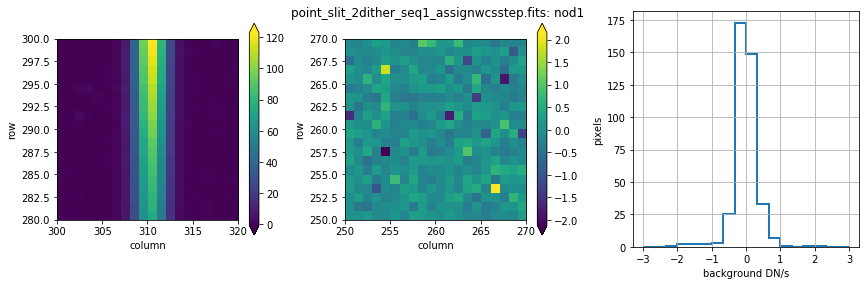

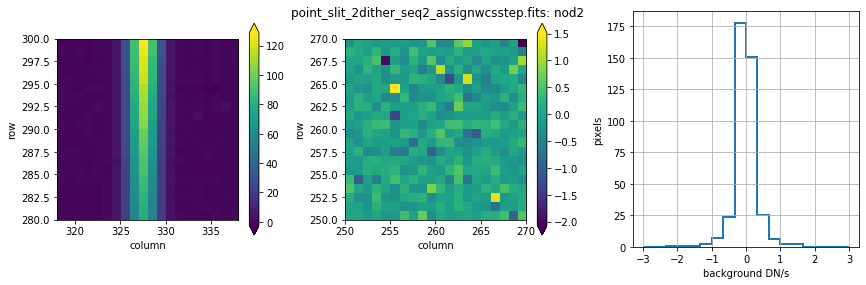

In [28]:
hdus = []
sci_ims = []
nod_ims = ['nod 1', 'nod 2']
reg_spec = {'nod1':{'row1': 280, 'row2': 300, 'col1': 300, 'col2': 320}, 
            'nod2': {'row1': 280, 'row2': 300, 'col1': 318, 'col2': 338}}
reg_blank = {'nod1': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}, 
             'nod2': {'row1': 250, 'row2': 270, 'col1': 250, 'col2': 270}}

for f in files:
    nodim = fits.open(f)
    #print(nodim.info())
    hdus.append(nodim)
    sci_ims.append(nodim['SCI'])
    im = nodim['SCI']
    
    # PLOT THE TWO NODS: SPECTRUM AND BLANK REGION
    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=[12,4])
    if 'seq1' in f:
        nn = 'nod1'
    else:
        nn = 'nod2'
    plt.suptitle('{0}: {1}'.format(f.split('/')[-1], nn), fontsize='large')
    implt0 = ax[0].imshow(im.data[reg_spec[nn]['row1']:reg_spec[nn]['row2'], reg_spec[nn]['col1']:reg_spec[nn]['col2']], extent=[reg_spec[nn]['col1'], reg_spec[nn]['col2'], reg_spec[nn]['row1'], reg_spec[nn]['row2']],origin='lower', interpolation='None')
    ax[0].set_xlabel('column')
    ax[0].set_ylabel('row')
    
    cbar = fig.colorbar(implt0, extend='both', shrink=0.9, ax=ax[0])
    
    implt1 = ax[1].imshow(im.data[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']], extent=[reg_blank[nn]['col1'], reg_blank[nn]['col2'], reg_blank[nn]['row1'], reg_blank[nn]['row2']],origin='lower', interpolation='None')
    ax[1].set_xlabel('column')
    ax[1].set_ylabel('row')
    cbar = fig.colorbar(implt1, extend='both', shrink=0.9, ax=ax[1])
    
    hbins = np.linspace(-3., +3., 19)
    implt2 = ax[2].hist(np.ravel(im.data[reg_blank[nn]['row1']:reg_blank[nn]['row2'], reg_blank[nn]['col1']:reg_blank[nn]['col2']]), bins=hbins, histtype='step', lw=2)
    ax[2].set_xlabel('background DN/s')
    ax[2].set_ylabel('pixels')
    ax[2].grid()
    
    fig.tight_layout()
    
    
    
    

### Manual subtraction check

Let's subtract nod 2 from nod 1, and vice versa, to act as comparison data for the pipeline step.

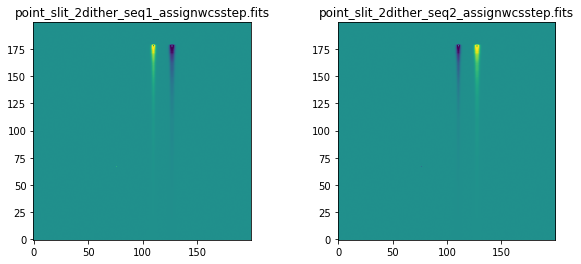

In [75]:
subcomp = []
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
for i, f in enumerate(files):
    
    if (i==0):
        bgr = files[1]
    elif (i==1):
        bgr = files[0]
    bgrmod = ImageModel(bgr)
    
    with datamodels.open(f) as im:
        sub = im.data - bgrmod.data
        subcomp.append(sub)
        ax[i].imshow(sub[200:400, 200:400], origin='lower', interpolation='None')
        ax[i].set_title('{}'.format(f.split('/')[-1]))
    


            

### Pipeline step method I: BackgroundStep.call()

Now we run the background subtraction step. Nod 2 is the background for Nod 1, and vice versa. So we should end up with 2 outputs, each with a positive and negative spectral trace, and the background subtracted. 

This is the first method we try, using BackgroundStep.call(). This takes the following input:
- science file
- background file, or list of background files

i.e. this does _not_ take an association as input. We do the following in this next step:

* create an instance of the step
* set the output directory
* set up the logger to create an output logfile
* call the step, and save the output to the output directory

In [43]:
bgrstep = BackgroundStep()
subims = []
outdir = './point_slit_2dither/output_files/'

for i, f in enumerate(files):
    print(f)
    #set up the logfile in the output directory:
    hdlr = logging.FileHandler(outdir+'lrs_slit_bgrsub_{}.log'.format(i))
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    bgrstep.log.addHandler(hdlr)
    bgrstep.log.setLevel(logging.WARNING)

    if (i==0):
        bgr = files[1]
    elif (i==1):
        bgr = files[0]
    print(bgr)
    subim = bgrstep.call(f, [bgr], save_results=True, output_dir=outdir)
    subims.append(subim)

2020-07-16 15:23:37,701 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.


./point_slit_2dither/input_files/point_slit_2dither_seq1_assignwcsstep.fits
./point_slit_2dither/input_files/point_slit_2dither_seq2_assignwcsstep.fits


2020-07-16 15:23:37,983 - CRDS - ERROR -  Error determining best reference for 'pars-backgroundstep'  =   Unknown reference type 'pars-backgroundstep'
2020-07-16 15:23:37,986 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2020-07-16 15:23:38,090 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args ('./point_slit_2dither/input_files/point_slit_2dither_seq1_assignwcsstep.fits', ['./point_slit_2dither/input_files/point_slit_2dither_seq2_assignwcsstep.fits']).
2020-07-16 15:23:38,092 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './point_slit_2dither/output_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}
2020-07-16 15:23:39,214 - stpipe.BackgroundStep - INFO - Saved model in ./point_slit_2dither/o

./point_slit_2dither/input_files/point_slit_2dither_seq2_assignwcsstep.fits
./point_slit_2dither/input_files/point_slit_2dither_seq1_assignwcsstep.fits


2020-07-16 15:23:39,506 - CRDS - ERROR -  Error determining best reference for 'pars-backgroundstep'  =   Unknown reference type 'pars-backgroundstep'
2020-07-16 15:23:39,508 - stpipe.BackgroundStep - INFO - BackgroundStep instance created.
2020-07-16 15:23:39,615 - stpipe.BackgroundStep - INFO - Step BackgroundStep running with args ('./point_slit_2dither/input_files/point_slit_2dither_seq2_assignwcsstep.fits', ['./point_slit_2dither/input_files/point_slit_2dither_seq1_assignwcsstep.fits']).
2020-07-16 15:23:39,616 - stpipe.BackgroundStep - INFO - Step BackgroundStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': './point_slit_2dither/output_files/', 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sigma': 3.0, 'maxiters': None}
2020-07-16 15:23:40,729 - stpipe.BackgroundStep - INFO - Saved model in ./point_slit_2dither/o

Compare the output against the manual check.

(6,)


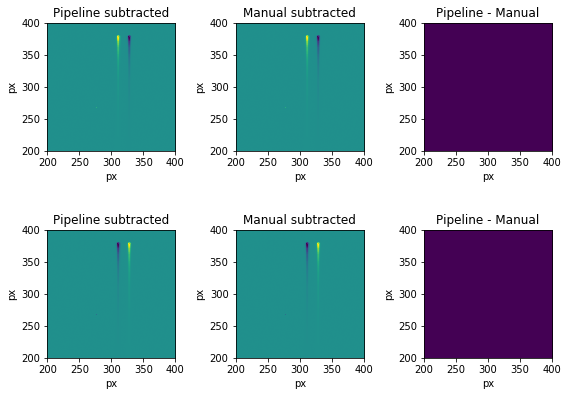

In [91]:
fig, _ax = plt.subplots(ncols=3, nrows=2, figsize=[8,6])
ax = _ax.flatten()

reg = [200, 400]

for i, (pp, cc) in enumerate(zip(subims, subcomp)):
    j = i*3
    ax[j].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j].set_title('Pipeline subtracted')
    ax[j].set_xlabel('px')
    ax[j].set_ylabel('px')
    ax[j+1].imshow(cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+1].set_title('Manual subtracted')
    ax[j+1].set_xlabel('px')
    ax[j+1].set_ylabel('px')
    ax[j+2].imshow(pp.data[reg[0]:reg[1], reg[0]:reg[1]]-cc[reg[0]:reg[1], reg[0]:reg[1]], origin='lower', interpolation='None', extent=[reg[0], reg[1], reg[0], reg[1]])
    ax[j+2].set_title('Pipeline - Manual')
    ax[j+2].set_xlabel('px')
    ax[j+2].set_ylabel('px')
    
    
    fig.tight_layout()

Compare histograms of the blank regions of science frames and subtracted frames. The two subtarcted histograms should be the same and centred close(r) to zero than the background regions in the science frames.

MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod1 = -0.0151
MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, nod2 = -0.0175
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod1 = 0.0025
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod1 = 0.0025
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, nod2 = -0.0025
MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, nod2 = -0.0025


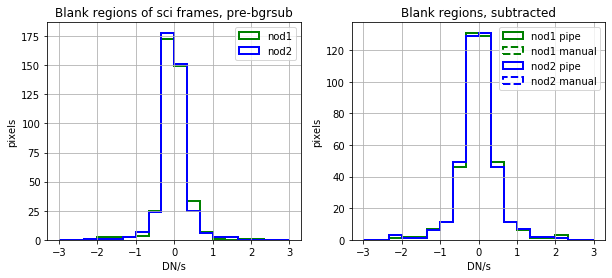

In [132]:
fig, _ax = plt.subplots(nrows=1, ncols=2, figsize=[10,4])
ax = _ax.flatten()

for f in files:
    im = ImageModel(f)
    if 'seq1' in f:
        lab = 'nod1'
        cc = 'g'
    else:
        lab = 'nod2'
        cc = 'b'
    ax[0].hist(np.ravel(im.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=cc, label=lab)
    ax[0].legend(prop={'size': 10})
    ax[0].set_title('Blank regions of sci frames, pre-bgrsub')
    ax[0].set_xlabel('DN/s')
    ax[0].set_ylabel('pixels')
    ax[0].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION BEFORE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(im.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    
    
for pp, cc in zip(subims, subcomp):
    if 'seq1' in pp.meta.filename:
        lab = 'nod1'
        col ='g'
    else:
        lab = 'nod2'
        col = 'b'
    ax[1].hist(np.ravel(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '-', label=lab+' pipe')
    ax[1].hist(np.ravel(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']]), bins=hbins, histtype='step', lw=2, color=col, ls = '--', label=lab+' manual')
    ax[1].legend(prop={'size': 10})
    ax[1].set_title('Blank regions, subtracted')
    ax[1].set_xlabel('DN/s')
    ax[1].set_ylabel('pixels')
    ax[1].grid(True)
    
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, PIPELINE SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(pp.data[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    print('MEAN VALUE OF BLANK SKY REGION AFTER SUBTRACTION, MANUAL SUBTRACTION, {0} = {1:.4f}'.format(lab, np.mean(cc[reg_blank[lab]['row1']:reg_blank[lab]['row2'], reg_blank[lab]['col1']:reg_blank[lab]['col2']])))
    


### Pipeline method II: running Spec2Pipeline() using an association as input